In [173]:
import pandas as pd
from pmdarima import auto_arima 
import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import warnings 
warnings.filterwarnings("ignore") 

In [2]:
us_confirmed_npl=pd.read_csv('./data/us_confirmed_npl.csv')
us_confirmed_npl.columns=['Date', 'Aggregated', 'Daily New']
us_confirmed_npl.head()

,Date,Aggregated,Daily New
0,1/22/2020,1,0.0
1,1/23/2020,1,0.0
2,1/24/2020,2,1.0
3,1/25/2020,2,0.0
4,1/26/2020,5,3.0


In [3]:
us_death_npl=pd.read_csv('./data/us_death_npl.csv')
us_death_npl.columns=['Date', 'Aggregated', 'Daily New']
us_death_npl.head()

,Date,Aggregated,Daily New
0,1/22/2020,0,0.0
1,1/23/2020,0,0.0
2,1/24/2020,0,0.0
3,1/25/2020,0,0.0
4,1/26/2020,0,0.0


In [4]:
us_conf_dnew=us_confirmed_npl.drop('Aggregated',axis=1)
us_conf_dnew['Date'] = pd.to_datetime(us_conf_dnew['Date'], format="%m/%d/%Y")
us_conf_dnew.set_index('Date',inplace=True)
us_conf_dnew.head()
us_dea_dnew=us_death_npl.drop('Aggregated',axis=1)
us_dea_dnew['Date'] = pd.to_datetime(us_dea_dnew['Date'], format="%m/%d/%Y")
us_dea_dnew.set_index('Date',inplace=True)
us_dea_dnew.head()

,Daily New
Date,
2020-01-22,0.0
2020-01-23,0.0
2020-01-24,0.0
2020-01-25,0.0
2020-01-26,0.0


#### Seasonal Decompostion on Time Series Data

<Figure size 432x288 with 0 Axes>

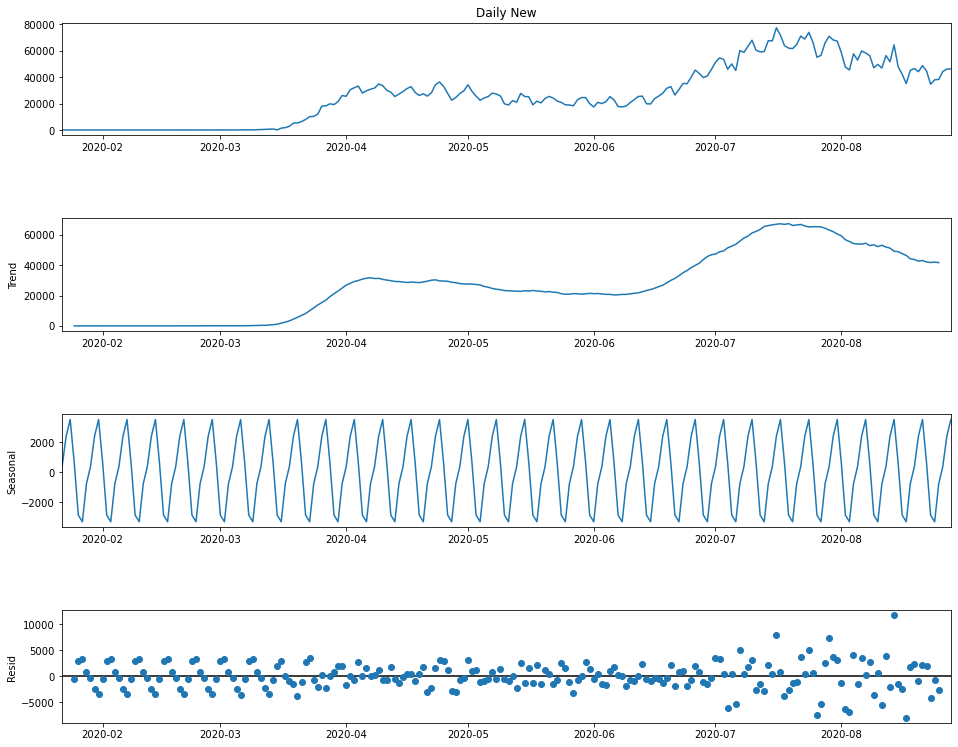

In [88]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(us_conf_dnew['Daily New'], model='additive')

fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 12)
fig.show()

The result of seasonal decomposition shows the US COVID-19 confirmed cases data has an upward trend with approximately weekly seasonoality. This is shown more clearly in the below plot of decomposition trend with actual data.

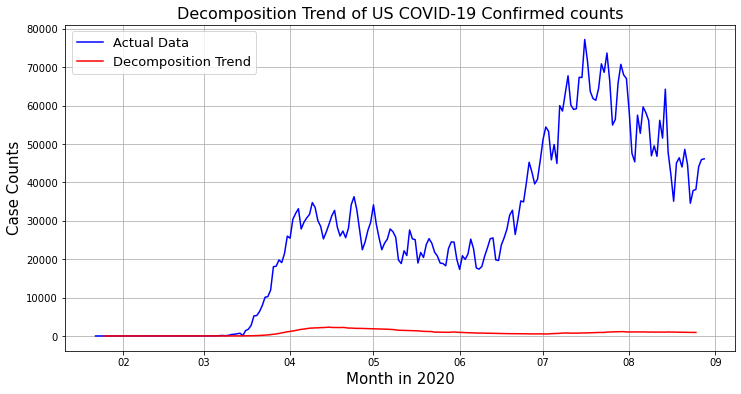

In [175]:
fig= plt.figure(figsize = (12, 6)) 
ax = fig.add_subplot(1, 1, 1) 
ax.grid(True)
month = mdates.MonthLocator(interval=1)
month_format = mdates.DateFormatter('%m')
ax.xaxis.set_major_locator(month)
ax.xaxis.set_major_formatter(month_format)
plt.plot(us_conf_dnew.index, us_conf_dnew['Daily New'], c='blue', label='Actual Data')
plt.plot(decomposition.trend.index, decomposition.trend, c='red', label='Decomposition Trend')
plt.title('Decomposition Trend of US COVID-19 Confirmed counts', fontsize=16)
plt.xlabel('Month in 2020', fontsize=15)
plt.ylabel('Case Counts', fontsize=15)
plt.legend(fontsize=13)
plt.show()

<Figure size 432x288 with 0 Axes>

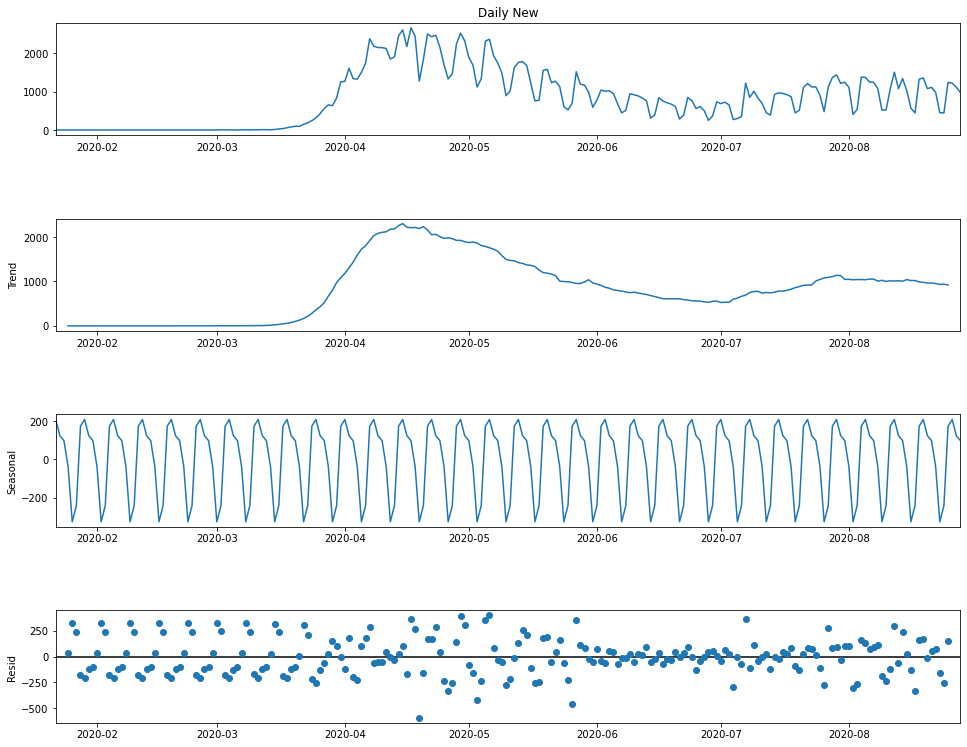

In [90]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(us_dea_dnew['Daily New'], model='additive')

fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 12)
fig.show()

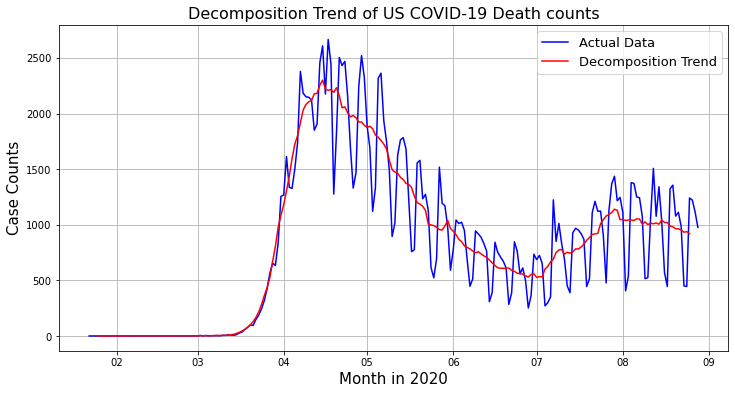

In [174]:
fig= plt.figure(figsize = (12, 6)) 
ax = fig.add_subplot(1, 1, 1) 
ax.grid(True)
month = mdates.MonthLocator(interval=1)
month_format = mdates.DateFormatter('%m')
ax.xaxis.set_major_locator(month)
ax.xaxis.set_major_formatter(month_format)
plt.plot(us_dea_dnew.index, us_dea_dnew['Daily New'], c='blue', label='Actual Data')
plt.plot(decomposition.trend.index, decomposition.trend, c='red', label='Decomposition Trend')
plt.title('Decomposition Trend of US COVID-19 Death counts', fontsize=16)
plt.xlabel('Month in 2020', fontsize=15)
plt.ylabel('Case Counts', fontsize=15)
plt.legend(fontsize=13)
plt.show()

Dickey-Fuller test to determine stationarity and obtain the degree of differencing needed

In [92]:
from statsmodels.tsa.stattools import adfuller

# original data ADF
result = adfuller(us_conf_dnew['Daily New'], autolag='AIC')
ADF=[[round(i,6) for i in result[0:2]]]

# 1st order differencing
result1 = adfuller(us_conf_dnew['Daily New'].diff().dropna(), autolag='AIC')
ADF.append([round(i,6) for i in result1[0:2]])

# 2nd order differencing
result2 = adfuller(us_conf_dnew['Daily New'].diff().diff().dropna(), autolag='AIC')
ADF.append([round(i,6) for i in result2[0:2]])

ADFresult = pd.DataFrame(ADF)
ADFresult.columns=['ADF Test Statistics', 'p-value']
ADFresult.index=['0th order differencing', '1st order differencing', '2nd order differencing']

ADFresult

,ADF Test Statistics,p-value
0th order differencing,-2.069027,0.257150
1st order differencing,-2.015798,0.279689
2nd order differencing,-6.310418,0.000000


In [93]:
def train_test_split(data, test_size=0.20):   #default 80% training, 20% testing
    split_day=int(math.floor((1-test_size)*(data.shape[0])))       # the first day of test
    train=data[['Daily New']].iloc[:split_day,:]
    test=data[['Daily New']].iloc[split_day:,:]
    return train, test, split_day

In [94]:
def smape_kun(y_true, y_pred):
    mape = np.mean(abs((y_true-y_pred)/y_true))*100
    smape = np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))).fillna(0))
    return mape, smape

In [106]:
from pmdarima.pipeline import Pipeline
from pmdarima.preprocessing import BoxCoxEndogTransformer
import pmdarima as pm

def auto_arima(data, test_size=0.20):
    train, test, split_day = train_test_split(data, test_size)
    
    model = pm.auto_arima(train,
                      test='adf',       # use adftest to find optimal 'd'
                      m=1,              # frequency of series
                      trace=False,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      seasonal=True,
                      stepwise=True)

    model.fit(train)
    predicted=model.predict(len(test))
    print(model.summary())
    MAPE, SMAPE=smape_kun(data[split_day:]['Daily New'], predicted)
    print('MAPE:', MAPE)
    print('SMAPE:', SMAPE)
    return model, predicted, split_day

In [107]:
def plot_diag(data, test_size=0.20):
    model, prediction, split_day=auto_arima(data, test_size)
    model.plot_diagnostics(figsize=(14,10))
    return model, data, split_day, prediction

In [108]:
def plot_test_group(data, split_day, prediction, name):
    plt.plot(data[['Daily New']], label="Actual Data")
    plt.plot(data.index[split_day:], prediction, color='r', label="Predicted Data")
    plt.title('US Actual vs. Predicted {} Case Counts in Test Group'.format(name), fontsize=16)
    plt.xlabel('Date', fontsize=16)
    plt.ylabel('Case Counts', fontsize=16)
    plt.xticks(rotation = 45)
    plt.legend(fontsize=13)
    plt.show()

In [163]:
from datetime import timedelta
def plot_forecast(data, model, name, days=30):
    model.fit(data)
    prediction=model.predict(days)   #predict next 30 days
    plt.plot(data[['Daily New']], label='Actual Data', color='b')
    #connect actual data to prediction
    temp=data[['Daily New']][-1:]
    plt.plot(data.index[-days-1:]+timedelta(days=days), np.insert(prediction, 0, temp), label="Forecast")
    plt.title('US {} Case Counts with a {}-day Forecast'.format(name, days), fontsize=16)
    plt.xlabel('Date', fontsize=16)
    plt.ylabel('Case Counts', fontsize=16)
    plt.xticks(rotation = 45)
    plt.legend(fontsize=13)
    plt.show()
    return pd.DataFrame(prediction,data.index[-days:]+timedelta(days=days))

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  176
Model:               SARIMAX(3, 1, 2)   Log Likelihood               -1605.809
Date:                Sat, 29 Aug 2020   AIC                           3225.618
Time:                        22:38:53   BIC                           3247.772
Sample:                             0   HQIC                          3234.604
                                - 176                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    401.1363    137.367      2.920      0.003     131.903     670.370
ar.L1          0.8276      0.059     13.914      0.000       0.711       0.944
ar.L2         -0.5018      0.075     -6.648      0.0

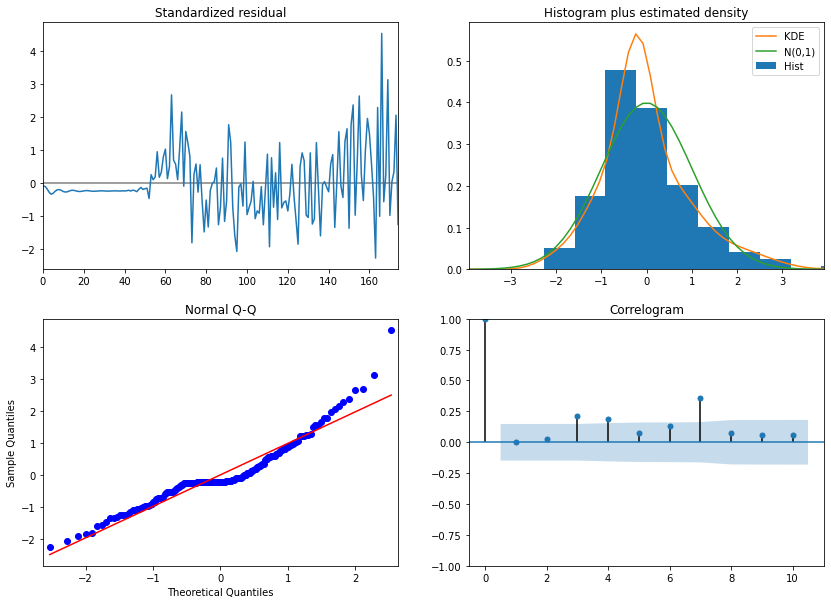

In [164]:
model, data, split_day, prediction = plot_diag(us_conf_dnew)

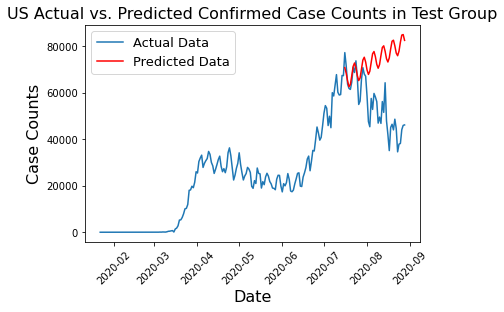

In [165]:
plot_test_group(data, split_day, prediction, 'Confirmed')

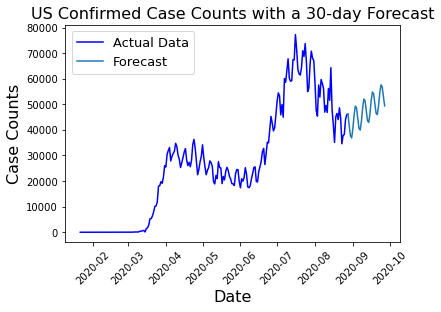

In [166]:
amira_us_confirmed_30=plot_forecast(data, model,'Confirmed', 30)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  176
Model:               SARIMAX(4, 1, 2)   Log Likelihood               -1170.621
Date:                Sat, 29 Aug 2020   AIC                           2355.241
Time:                        22:39:05   BIC                           2377.395
Sample:                             0   HQIC                          2364.227
                                - 176                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8099      0.072     11.178      0.000       0.668       0.952
ar.L2         -0.9846      0.085    -11.596      0.000      -1.151      -0.818
ar.L3          0.2306      0.075      3.057      0.0

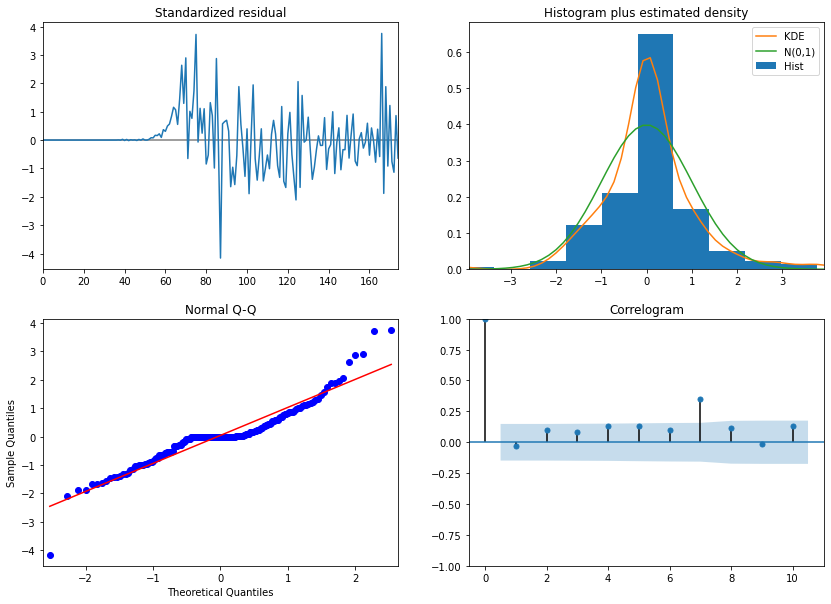

In [167]:
model, data, split_day, prediction = plot_diag(us_dea_dnew)

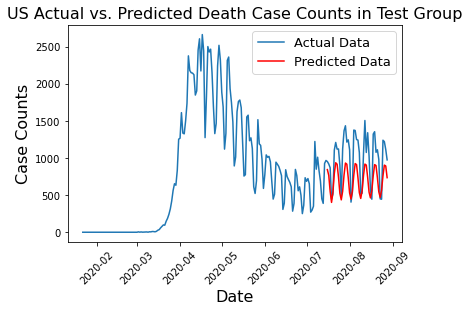

In [168]:
plot_test_group(data, split_day, prediction, 'Death')

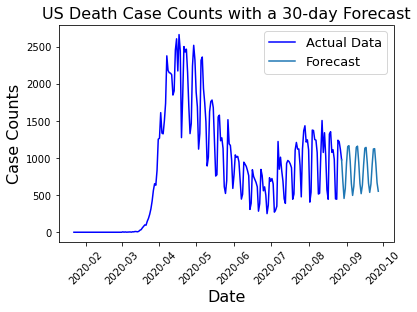

In [169]:
amira_us_death_30=plot_forecast(data, model, 'Death', 30)

In [170]:
amira_us_confirmed_30.columns=['US Confirmed ARIMA Forecast']
amira_us_death_30.columns=['US Death ARIMA Forecast']

In [172]:
amira_us_death_30.to_csv('./forecast/amira_us_death_30.csv')
amira_us_confirmed_30.to_csv('./forecast/amira_us_confirmed_30.csv')